In [1]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import unicodedata
from io import open
import string
import re
import random

In [2]:
# loading data into the program
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Checking directory of data files
!ls; cd /content/drive/My\ Drive/Machine\ Translation; ls


drive  sample_data
english_sampled.txt  en_hi.pkl	hindi_sampled.txt  my_cp.pth.tar


In [5]:
SOS = 0
EOS = 1

class Language_Prepare:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "SOS", 1: "EOS"}
    self.n_words = 2

  def processCorpus(self, sentence):
    for word in sentence.split(' '):
      if word not in self.word2index:
        self.word2index[word] = self.n_words
        self.word2count[word] = 1
        self.index2word[self.n_words] = word
        self.n_words = self.n_words + 1
      
      else:
        self.word2count[word] += 1


In [6]:
# load data

import pandas as pd
df = pd.read_pickle('/content/drive/My Drive/Machine Translation/en_hi.pkl')

df.head()

english                           hindi
57382              Who is this man?\n             -ये आदमी कौन है ?\n
28149        And the other brother?\n                 और दूसरे भाई?\n
80284  - Greetings, Mustakeen bhai.\n        नमस्ते, Mustakeen भाई।\n
63596     Please, reason with them.\n  कृपया, उन लोगों के साथ कारण.\n
9459        There's a howling gale.\n             तेज़ हवा आ रही है।\n

In [7]:
# preprocessing

exclude = set(string.punctuation)

df['english'] = df['english'].apply(lambda x: x.lower())
df['hindi'] = df['hindi'].apply(lambda x: x.lower())

df['english'] = df['english'].apply(lambda x: re.sub("'", '', x))
df['hindi'] = df['hindi'].apply(lambda x: re.sub("'", '', x))

df['english'] = df['english'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df['hindi'] = df['hindi'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

df['english'] = df['english'].apply(lambda x : x[:-1])
df['hindi'] = df['hindi'].apply(lambda x : x[:-1])

df['english'] = df['english'].apply(lambda x : x.strip())
df['hindi'] = df['hindi'].apply(lambda x : x.strip())

df['english'] = df['english'].apply(lambda x: re.sub(" +", " ", x))
df['hindi'] = df['hindi'].apply(lambda x: re.sub(" +", " ", x))

# df['hindi'] = df['hindi'].apply(lambda x: str(SOS) + ' ' + x + ' ' + str(EOS))

In [8]:
df.head()

english                       hindi
57382           who is this man              ये आदमी कौन है
28149     and the other brother                और दूसरे भाई
80284  greetings mustakeen bhai       नमस्ते mustakeen भाई।
63596   please reason with them  कृपया उन लोगों के साथ कारण
9459      theres a howling gale           तेज़ हवा आ रही है।

In [10]:
MAX = 50

def filter(eng, hin):
  pairs = []
  if len(eng.split(' ')) < MAX and len(hin.split(' ')) < MAX:
    # pair = []
    pairs.append(eng)
    pairs.append(hin)
    # pairs.append(pair)

  return pairs


def preprocessSentences():
  pairs = []
  for i in range(len(df)):
    pairs.append(filter(df.iloc[i]['english'], df.iloc[i]['hindi']))
  
  hindi = Language_Prepare('hin')
  english = Language_Prepare('eng')

  for i in range(len(pairs)):
    english.processCorpus(pairs[i][0])
    hindi.processCorpus(pairs[i][1])
  
  print(hindi.name, hindi.n_words)
  print(english.name, english.n_words)
  print(pairs)
  return pairs, english, hindi

pairs, english, hindi = preprocessSentences()
train_dataset, test_dataset = torch.utils.data.random_split(pairs, [7000, 3000])
test_dataset, validation_dataset = torch.utils.data.random_split(test_dataset, [2000, 1000])


hin 6791
eng 5602
[['who is this man', 'ये आदमी कौन है'], ['and the other brother', 'और दूसरे भाई'], ['greetings mustakeen bhai', 'नमस्ते mustakeen भाई।'], ['please reason with them', 'कृपया उन लोगों के साथ कारण'], ['theres a howling gale', 'तेज़ हवा आ रही है।'], ['no you dont', 'नहीं कभी नहीं'], ['the violence the rage', 'हिंसा स्पूर्ति।'], ['signal decoy in place', 'सिग्नल जगह में लूभाव।'], ['you guys come with', 'तुम लोग इसे ले तो आये हो'], ['how long you staying', 'तुम कब तक रह'], ['who is this now', 'अब यह कौन है'], ['hows rosie doing jim', 'कैसे रोजी जिम कर रहा है'], ['100 feet radius clear', '100 फुट त्रिज्या स्पष्ट'], ['its not safe', 'वहाँ खतरा है।'], ['trevor no no dont', 'नहीं नहीं नहीं करते हैं'], ['your passport is ready', 'आपका पासपोर्ट तैयार है।'], ['come on lets go', 'चलो चलते हैं।'], ['fruit of thy womb', 'तुम्हारे पेट का फल'], ['agh that is tight', 'तंग है कि आह'], ['is this wool', 'यह ऊन है'], ['no she is different', 'नहीं है वह अलग है।'], ['ask any of them', 'उनमें स

In [18]:
# building the encoder from here
%matplotlib inline
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)

  def forward(self, inval, hidden):
    embedded = self.embedding(inval).view(1,1,-1)
    outval = embedded
    outval, hidden = self.gru(outval, hidden)
    return outval, hidden


In [19]:
%matplotlib inline
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights


In [20]:
def indexesFromSentence(lang, sentence):
  return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
  indexes = indexesFromSentence(lang, sentence)
  indexes.append(EOS)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(-1,1)

def tensorsFromPair(pair):
  input_tensor = tensorFromSentence(english, pair[0])
  target_tensor = tensorFromSentence(hindi, pair[1])
  return (input_tensor, target_tensor)

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX):
  teacher_f = 0.5
  encoder_hidden = torch.zeros(1,1,encoder.hidden_size,device=device)

  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_tensor.size(0)
  target_length = target_tensor.size(0)

  encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

  loss = 0

  for ei in range(0, input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0,0]

  decoder_input = torch.tensor([[SOS]], device=device)

  decoder_hidden = encoder_hidden

  use_tf = True if random.random() < teacher_f else False
  
  for di in range(0, target_length):
    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
    loss += criterion(decoder_output, target_tensor[di])
    decoder_input = target_tensor[di]

  loss.backward()
  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item() / target_length

In [21]:
# plotting the results

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
  plt.figure()
  fig, ax = plt.subplots()
  loc = ticker.MultipleLocator(base=0.2)
  ax.yaxis.set_major_locator(loc)
  plt.plot(points)

In [22]:
def run_training(encoder, decoder, n_iters, eta, plot_every=1000):
  plot_losses = []
  print_loss = 0
  plot_loss = 0

  encoder_optimizer = optim.SGD(encoder.parameters(), lr=eta)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=eta)
  training_pairs = [tensorsFromPair(random.choice(train_dataset)) for i in range(0, n_iters)]

  criterion = nn.NLLLoss()

  for iter in range(1, n_iters+1):
    print(f"[Epoch {iter} / {n_iters}]")

    checkpoint = {
        "encoder": encoder.state_dict(),
        "optimizer_encoder": encoder_optimizer.state_dict(),
        "decoder": decoder.state_dict(),
        "optimizer_decoder": decoder_optimizer.state_dict()
    }

    torch.save(checkpoint, "/content/drive/My Drive/Machine Translation/my_cp_attn.pth.tar")

    training_pair = training_pairs[iter-1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    print_loss += loss
    plot_loss += loss

    if iter%plot_every == 0:
      plotAverage = plot_loss / plot_every
      plot_losses.append(plotAverage)
      plot_loss = 0

  showPlot(plot_losses)


[Epoch 1 / 4000]
[Epoch 2 / 4000]
[Epoch 3 / 4000]
[Epoch 4 / 4000]
[Epoch 5 / 4000]
[Epoch 6 / 4000]
[Epoch 7 / 4000]
[Epoch 8 / 4000]
[Epoch 9 / 4000]
[Epoch 10 / 4000]
[Epoch 11 / 4000]
[Epoch 12 / 4000]
[Epoch 13 / 4000]
[Epoch 14 / 4000]
[Epoch 15 / 4000]
[Epoch 16 / 4000]
[Epoch 17 / 4000]
[Epoch 18 / 4000]
[Epoch 19 / 4000]
[Epoch 20 / 4000]
[Epoch 21 / 4000]
[Epoch 22 / 4000]
[Epoch 23 / 4000]
[Epoch 24 / 4000]
[Epoch 25 / 4000]
[Epoch 26 / 4000]
[Epoch 27 / 4000]
[Epoch 28 / 4000]
[Epoch 29 / 4000]
[Epoch 30 / 4000]
[Epoch 31 / 4000]
[Epoch 32 / 4000]
[Epoch 33 / 4000]
[Epoch 34 / 4000]
[Epoch 35 / 4000]
[Epoch 36 / 4000]
[Epoch 37 / 4000]
[Epoch 38 / 4000]
[Epoch 39 / 4000]
[Epoch 40 / 4000]
[Epoch 41 / 4000]
[Epoch 42 / 4000]
[Epoch 43 / 4000]
[Epoch 44 / 4000]
[Epoch 45 / 4000]
[Epoch 46 / 4000]
[Epoch 47 / 4000]
[Epoch 48 / 4000]
[Epoch 49 / 4000]
[Epoch 50 / 4000]
[Epoch 51 / 4000]
[Epoch 52 / 4000]
[Epoch 53 / 4000]
[Epoch 54 / 4000]
[Epoch 55 / 4000]
[Epoch 56 / 4000]
[

<Figure size 432x288 with 0 Axes>

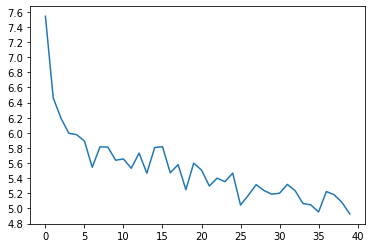

In [23]:
# running training
%matplotlib inline

hidden_size = 256
encoder1 = EncoderRNN(english.n_words, hidden_size).to(device)
decoder1 = AttnDecoderRNN(hidden_size, hindi.n_words).to(device)

run_training(encoder1, decoder1, 4000, 0.01, plot_every=100)

In [27]:
# Evaluate model

def evaluate(encoder, decoder, sentence, MAX=50):
  with torch.no_grad():
    input_tensor = tensorFromSentence(english, sentence)
    input_length = input_tensor.size()[0]
    encoder_hidden = torch.zeros(1, 1, encoder.hidden_size, device=device)
    encoder_outputs = torch.zeros(MAX, encoder.hidden_size, device=device)

    for ei in range(0, input_length):
      encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0,0]
    
    decoder_input = torch.tensor([[SOS]], device=device) 
    decoder_hidden = encoder_hidden

    hindi_words = []
    decoder_attentions = torch.zeros(MAX, MAX)

    for di in range(0,MAX):
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
      topv, topi = decoder_output.data.topk(1)

      if topi.item() == EOS:
        hindi_words.append('')
        break
        
      else:
        hindi_words.append(hindi.index2word[topi.item()])

      decoder_input = topi.squeeze().detach()

    return hindi_words, decoder_attentions[:di + 1]

def evaluateRandomly(encoder, decoder, n):
  for i in range(0,n):
    pair = test_dataset[i]
    print('English: ', pair[0])
    
    output_words, attention = evaluate(encoder, decoder, pair[0], 50)
    sentenceOut = ' '.join(output_words)

    print('Hindi predicted: ', sentenceOut)

    act = pair[1].split()
    pred = sentenceOut.split()

    from nltk.translate.bleu_score import sentence_bleu
    score = sentence_bleu([act], pred)
    print(score)


In [28]:
%matplotlib inline
evaluateRandomly(encoder1, decoder1, 2000)

English:  it is a database maam
Hindi predicted:  एक एक है 
0.4639247374454443
English:  until your heart stops beating
Hindi predicted:  और क्या है 
0.10283257773094409
English:  and then were dead
Hindi predicted:  और और क्या है 
0.42888194248035344
English:  can we leave now
Hindi predicted:  हम यहाँ के लिए 
0.5506953149031838
English:  can we trust him
Hindi predicted:  हम अपनी के लिए 
0.42888194248035344
English:  shes fond of stratagems
Hindi predicted:  और क्या है 
0.14351442318493668
English:  i wont do anything
Hindi predicted:  मैं तुम मुझे नहीं कर रहे हैं 
0.7311104457090247
English:  i cant sam
Hindi predicted:  मैं भी भी नहीं है 
0.668740304976422
English:  i like you very much
Hindi predicted:  मैं तुम मुझे नहीं कर रहे हैं 
0.6147881529512643
English:  im really lucky today
Hindi predicted:  मैं भी नहीं कर रहे हैं 
0
English:  its like a horse
Hindi predicted:  एक एक है 
0.27952792741962756
English:  mako listen to me
Hindi predicted:  मुझे मुझे नहीं है 
0
English:  thats

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Hindi predicted:  और क्या है 
0
English:  tom back in the game
Hindi predicted:  हाँ और क्या है 
0
English:  whyd you come to me
Hindi predicted:  तुम मुझे पता है 
0
English:  he looks real bad
Hindi predicted:  और क्या है 
0.27952792741962756
English:  and here i heard
Hindi predicted:  मैं यहाँ भी नहीं है 
0.7952707287670506
English:  he calls me a barbarian
Hindi predicted:  एक एक की जरूरत है 
0.6511126026643229
English:  this is amazing
Hindi predicted:  हाँ है 
0.510029457493824
English:  echo team hold fire
Hindi predicted:  और क्या है 
0
English:  first day of panda training
Hindi predicted:  और क्या है 
0
English:  you want some fresh air
Hindi predicted:  तुम मुझे पता है 
0
English:  do you hate me
Hindi predicted:  तुम मुझे क्या कर रहे हैं 
0.7598356856515925
English:  local lawyer asap
Hindi predicted:  और क्या है 
0
English:  this is flesh and blood
Hindi predicted:  और और क्या है 
0.5506953149031838
English:  you understand this dont you
Hindi predicted:  तुम क्या कर रहे ह

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Hindi predicted:  मैं एक भी नहीं है 
0
English:  you wanna sit down
Hindi predicted:  तुम क्या कर रहे हैं 
0
English:  all right forget it
Hindi predicted:  यह एक है 
0.3324166001293853
English:  what should i do now
Hindi predicted:  मैं तुम मुझे नहीं कर रहे हैं 
0.6147881529512643
English:  i am not being unreasonable
Hindi predicted:  मैं भी नहीं है 
0.30934850332660563
English:  teddy if you please
Hindi predicted:  तुम क्या कर रहे हैं 
0
English:  blow the damn horn boy
Hindi predicted:  और क्या है 
0
English:  you sent the universe mail
Hindi predicted:  तुम क्या कर रहे हैं 
0
English:  we call this place loserville
Hindi predicted:  और क्या है 
0
English:  possibly the pretty face
Hindi predicted:  और क्या है 
0
English:  get off the street
Hindi predicted:  और क्या है 
0
English:  im so so sorry
Hindi predicted:  मैं भी नहीं नहीं है 
0
English:  look youre pentecosts bright idea
Hindi predicted:  क्या है कि तुम क्या कर रहे हैं 
0.34665771270955187
English:  i fucked up at all
H

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Streaming output truncated to the last 5000 lines.
0
English:  guys keep your eyes open
Hindi predicted:  हाँ मैं एक की जरूरत है 
0
English:  aint she a beauty
Hindi predicted:  एक एक की जरूरत है 
0.668740304976422
English:  tony looks really good
Hindi predicted:  और क्या है 
0.20029051217596075
English:  time has changed nothing
Hindi predicted:  हाँ यह एक है 
0
English:  hes hurt wheres oracle
Hindi predicted:  और क्या है 
0
English:  why are you late
Hindi predicted:  तुम क्या कर रहे हैं 
0
English:  your master is thirsty
Hindi predicted:  और क्या है 
0
English:  we were playing soccer
Hindi predicted:  हम एक के लिए 
0.5506953149031838
English:  hes got my parents
Hindi predicted:  और एक के लिए 
0
English:  then swim towards it honey
Hindi predicted:  मैं एक भी नहीं है 
0
English:  consider all your options
Hindi predicted:  तुम क्या कर रहे हैं 
0
English:  sir is everything allright
Hindi predicted:  हाँ है कि एक है 
0.668740304976422
English:  i cant feel my legs
Hindi predicted